In [1]:
import sys

preprocessing_path = 'C:\\Users\\joshh\\Desktop\\Uni\\Soton Uni - Yr 3\\COMP3200\\fake-news-profiling\\classifier\\preprocessing'
if preprocessing_path not in sys.path:
    sys.path.insert(1, preprocessing_path)

notif_path = 'C:\\Users\\joshh\\Desktop\\Uni\\Soton Uni - Yr 3\\COMP3200\\fake-news-profiling\\classifier\\notifications'
if notif_path not in sys.path:
    sys.path.insert(1, notif_path)

In [2]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf

from ipynb.fs.full.parse_datasets import parse_dataset, split_dataset
import ipynb.fs.full.preprocessing as process
import ipynb.fs.full.bert_fake_news_classifier as bclf
from ipynb.fs.full.notif_email import send_email

# Dataset

In [3]:
# Load the saved dataset split
def load_data():
    return np.load("datasets/en_split_data.npy", allow_pickle=True)

(tweet_train, label_train, 
 tweet_val, label_val, 
 tweet_test, label_test) = load_data()

In [4]:
# Remove HTML/XML tags
preprocessor = process.BertTweetFeedDataPreprocessor(transformers=[process.replace_xml_and_html])
tweet_train_processed = preprocessor.transform(tweet_train)
tweet_val_processed = preprocessor.transform(tweet_val)
tweet_test_processed = preprocessor.transform(tweet_test)

# Data extraction

In [5]:
from sklearn.preprocessing import normalize

import string
import demoji
import re
from pyphen import Pyphen

In [6]:
# Stats extraction helper functions
digits = set("0123456789")
printable = set(string.printable)
punctuation = set(string.punctuation)
punctuation.remove('#')

pyphen = Pyphen(lang='en')


def clean_text(text, remove_punc=True, remove_non_print=True, remove_emojis=True, 
              remove_digits=True, remove_tags=False):
    """ Clean text by removing certain characters (e.g. punctuation) """
    if remove_emojis:
        text = demoji.replace(text, "")
        
    chars = []
    for char in text:
        if not ((remove_punc and char in punctuation) or
            (remove_non_print and char not in printable) or
            (remove_digits and char in digits)):
            chars.append(char)

    cleaned = "".join(chars)
    if remove_tags:
        return re.sub('#[A-Z]+#', "", cleaned)
    
    return cleaned


def tweets_to_words(user_tweets, **kwargs):
    return [clean_text(tweet, **kwargs).split() for tweet in user_tweets]


def std_dev(datapoints, mean, num_datapoints=100):
    diff = datapoints - mean
    return np.sqrt(np.sum(diff ** 2, axis=0)/100)


def emoji_chars(user_tweets):
    """ Returns an array of lists of emojis used in each of the users tweets"""
    return [demoji.findall_list(tweet) for tweet in user_tweets]


def syllables(word):
    """ Counts the number of syllables in a word """
    return pyphen.inserted(word).count('-') + 1


def flatten(xss):
    return [x for xs in xss for x in xs]

In [7]:
from collections.abc import Iterable

class TweetStatsExtractor:
    def __init__(self, extractors):
        if len(extractors) == 0:
            raise Exception("Must pass at least one extracting function")

        self.extractors = extractors
    
    def transform(self, X, normalize_data=False):
        result = []
        for user_tweets in X:
            if len(self.extractors) > 1:
                result.append(np.concatenate([self._apply(f, user_tweets) for f in self.extractors]))
            else:
                result.append(self._apply(self.extractors[0], user_tweets))
        
        return np.asarray(normalize(result) if normalize_data else result)
    
    def _apply(self, extractor, data):
        result = extractor(data)
        if isinstance(result, Iterable):
            return result
        else:
            return np.asarray([result])

# Classifier evaluation

In [45]:
from tqdm import tqdm
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, accuracy_score, log_loss
from sklearn.decomposition import PCA
from xgboost import XGBClassifier

In [109]:
grid_search_estimators = [XGBClassifier, RandomForestClassifier, LogisticRegression, SVC]
grid_search_param_grids = [
    {"learning_rate": [0.0001, 0.001, 0.01, 0.1, 0.3],
     "gamma": list(range(5)),
     "max_depth": list(range(1, 5)),
     "min_child_weight": list(range(7)),
     "subsample": [0.2, 0.5, 0.7, 1],
     "colsample_bytree": [0.5, 0.7, 1],
     "colsample_bylevel": [0.5, 0.7, 1],
     "colsample_bynode": [0.5, 0.7, 1],
     "reg_lambda": [0.01, 0.1, 0.2, 0.5],
     "reg_alpha": [0.01, 0.1, 0.2, 0.5]},
    {"n_estimators": [100, 200, 300, 400, 500], 
     "min_samples_split": list(range(1, 10)),
     "min_samples_leaf": list(range(1, 16)),
     "min_impurity_decrease": np.linspace(0, 1, 11)},
    {"penalty": ["l1", "l2"], 
     "C": [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 768, 1024, 1280], 
     "solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]},
    {"C": [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 768, 1024, 1280], 
     "kernel": ["linear", "poly", "rbf", "sigmoid"], 
     "probability": [True]},
]

def grid_search(X_train, y_train, X_val, y_val, estimators=grid_search_estimators, param_grids=grid_search_param_grids):
    """ 
    Performs a GridSearchCV on the training data, and then evaluates using the validation data.
    Uses a pipeline to find the best K features to use from the training data.
    Returns a list of each estimator with their best parameters, as well as a dataframe containing 
    evaluation data.
    """
    # Ouput dataframe of results
    best_df = pd.DataFrame(columns=["Estimator", "Mean CV Loss", "Mean CV F1", "Mean CV Accuracy", "Val Loss", 
                                    "Val Precision", "Val Recall", "Val F1", "Val Accuracy"])
    best_params = []
    searches = []
    
    # Scale data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    
    # Apply PCA to remove multicollinearity
    pca = PCA()
    X_train = pca.fit_transform(X_train)
    X_val = pca.transform(X_val)
    
    # Perform grid searches for each estimator
    for i, (estimator, param_grid) in tqdm(enumerate(zip(estimators, param_grids)), desc="Estimators", total=len(estimators)):
        # Perform a GridSearchCV
        search = GridSearchCV(
            estimator(), 
            param_grid, 
            n_jobs=-1, 
            scoring={
                "accuracy": make_scorer(accuracy_score), 
                "f1": make_scorer(f1_score, pos_label="1"),
                "loss": make_scorer(log_loss, greater_is_better=False, needs_proba=True),
            }, 
            refit="loss",
        )
        search.fit(X_train, y_train)

        # Collect results
        best_index = search.cv_results_['params'].index(search.best_params_)
        y_train_pred = search.predict(X_train)
        y_val_pred = search.predict(X_val)

        best_df.loc[i] = [estimator.__name__, 
                          abs(search.cv_results_['mean_test_loss'][best_index]), 
                          search.cv_results_['mean_test_f1'][best_index],
                          search.cv_results_['mean_test_accuracy'][best_index],
                          log_loss(y_val, search.predict_proba(X_val)), 
                          precision_score(y_val, y_val_pred, pos_label="1"),
                          recall_score(y_val, y_val_pred, pos_label="1"),
                          f1_score(y_val, y_val_pred, pos_label="1"),
                          accuracy_score(y_val, y_val_pred)]
        best_params.append((estimator.__name__, search.best_params_))
        searches.append((estimator.__name__, search))
    
    return best_params, searches, best_df

SyntaxError: invalid syntax (<ipython-input-109-e2c4ec2c48ba>, line 10)

# Readability model
* Extract statistical readability from user tweets:
    * Number of tags (hashtags, mentions, URLs) (https://www.aclweb.org/anthology/U19-1003.pdf, http://ceur-ws.org/Vol-2696/paper_189.pdf)
    * Number of emojis (https://www.aclweb.org/anthology/U19-1003.pdf, http://ceur-ws.org/Vol-2696/paper_189.pdf)
    * Ratio of words to sentences and syllables to words:
        * Flesch-Kincaid grade level, on corrected (and non-corrected) tweets (stripped of unicode and tags, spelling corrected) (https://www.aclweb.org/anthology/U19-1003.pdf)
        * Flesch Reading Ease, modified for short tweet lengths (https://arxiv.org/ftp/arxiv/papers/1401/1401.6058.pdf, https://www.aclweb.org/anthology/U19-1003.pdf)
        * Both of these measurements use the ratio of words to sentences and syllables to words. Since we are using these in a model which will apply weights to these ratios, we don't need to use these scoring functions. Instead we will just make features using the ratios themselves.
        * Note that https://arxiv.org/ftp/arxiv/papers/1401/1401.6058.pdf found that tweets are poorly structured and so assumed that each tweet was a single sentence. This reduces the ratio to just the total number of words per tweet.
    * Tweet lengths (in words and characters) (https://www.aclweb.org/anthology/U19-1003.pdf, http://ceur-ws.org/Vol-2696/paper_189.pdf)
    * Type-token ratio (num_unique_words/total_num_words) (http://ceur-ws.org/Vol-2696/paper_189.pdf)
    * Retweet ratio (num_retweets/total_num_tweets) (http://ceur-ws.org/Vol-2380/paper_263.pdf, http://ceur-ws.org/Vol-2380/paper_189.pdf)
    * Number of truncated tweets (end with a ...) (http://ceur-ws.org/Vol-2696/paper_189.pdf, http://ceur-ws.org/Vol-2380/paper_189.pdf)
    * Use of punctuation marks (!,?, etc) (http://ceur-ws.org/Vol-2380/paper_263.pdf)
    * Use of numerical values
    * Use of personal pronouns (https://sml.stanford.edu/ml/2008/01/hancock-dp-on-lying.pdf)
    * chars to words ratio
    * quote counts
    * capitalisation counts


* "An Ensemble Model Using N-grams and Statistical Features to Identify Fake News Spreaders on Twitter" paper (http://ceur-ws.org/Vol-2696/paper_189.pdf) built a statistical model to support their N-gram model for this task (and won). "FacTweet: Profiling Fake News Twitter Accounts" used statistical information, such as emotions, style and sentiment to profile fake news spreading users.
* In "A stylometric Inquiry into Hyperpartisan and Fake News" paper, they used 10 readability scores to help classify hyperpartisan news. "Automatic Detection of Fake News" paper also used readability features, such as the number of characters, complex words, long words, number of syllables, word types, and number of paragraphs.

In [48]:
from collections import Counter
from functools import reduce, partial
import nltk

In [49]:
# Extractor functions (to be used in TweetStatsExtractor)
def tag_counts(user_tweets, tags=['#USER#', '#HASHTAG#', '#URL#']):
    """ Returns the average number of tag used, for each tag in tags """
    return np.mean([[tweet.count(tag) for tag in tags] for tweet in user_tweets], axis=0)


def retweet_ratio(user_tweets):
    """ Returns the ratio of retweets to regular tweets """
    retweets = 0
    second_retweets = 0
    for tweet in user_tweets:
        if tweet.startswith("RT"):
            retweets += 1
    
    return retweets / len(user_tweets)


def emojis_count(user_tweets):
    """ Returns the following emoji counts for this user: total number of emojis used, average number of emojis used 
    per tweet, type-token ratio of emojis (uniqueness of emojis used) """
    tweet_emojis = emoji_chars(user_tweets)
    flattened_tweet_emojis = flatten(tweet_emojis)
    
    total_num_emojis = len(flattened_tweet_emojis)
    emoji_type_token_ratio = (len(Counter(flattened_tweet_emojis)) / total_num_emojis) if total_num_emojis > 0 else 0
    return np.asarray([total_num_emojis, emoji_type_token_ratio])


def syllables_to_words_ratios(user_tweets):
    """ Returns the overall, average, min, and max ratios of the number of syllables to the number of words """
    tweet_words = tweets_to_words(user_tweets, remove_tags=True)
    tweet_syllables = [sum(map(syllables, words)) for words in tweet_words]
    per_tweet_ratios = [tweet_syllables[i] / max(1, len(tweet_words[i])) for i in range(len(tweet_words))]
    
    overall_ratio = sum(tweet_syllables) / max(1, sum(map(len, tweet_words)))
    mean_ratio = np.mean(per_tweet_ratios)
    min_ratio = min(per_tweet_ratios)
    max_ratio = max(per_tweet_ratios)
    return np.asarray([overall_ratio, mean_ratio, min_ratio, max_ratio])


def average_tweet_lengths(user_tweets):
    """ Returns the average tweet lengths in words and characters """
    mean_words = np.mean(list(map(len, tweets_to_words(user_tweets, remove_tags=True))))
    mean_chars = np.mean(list(map(len, map(partial(clean_text, remove_tags=True), user_tweets))))
    return np.asarray([mean_words, mean_chars])


def word_type_to_token_ratio(user_tweets):
    """ Returns the ratio of unique words to the total number of words in all of a users tweets """
    words = flatten(tweets_to_words(user_tweets, remove_tags=True))
    return len(Counter(list(words))) / len(words)


def truncated_tweets(user_tweets):
    """ Returns the number of truncated tweets """
    count = 0
    for tweet in user_tweets:
        if re.match(".*\.\.\.(?: #URL#)?$", tweet) is not None:
            count += 1
        
    return count


def punctuation_counts(user_tweets, punctuation_marks = "!?,:"):
    """ Returns the average number of each punctuation character in the users tweets, for each punctuation character 
    in punctuation_marks. Also returns the punctuation type-to-token ratio of all of the users tweets """
    all_punc = [c for tweet in user_tweets 
                for c in clean_text(tweet, remove_punc=False, remove_tags=True) if c in punctuation]
    punc_ttr = len(Counter(all_punc)) / max(1, len(all_punc))
    punc_counts = [[tweet.count(punctuation) for punctuation in punctuation_marks] for tweet in user_tweets]
    mean_punc_counts = np.mean(punc_counts, axis=0)
    return np.concatenate([mean_punc_counts, [punc_ttr]])


def number_counts(user_tweets):
    """ Returns the following counts: number of numerical values in the users tweets (e.g. "7,000"), number of 
    monetary values in the users tweets (e.g. "$90,000", "£9.35") """
    number_matcher = "\d+(?:,\d+)*(?:\.\d+)?"
    numbers = sum([len(re.findall(f"(?:^| )(?<![£$€]){number_matcher}", tweet)) for tweet in user_tweets])
    money = sum([len(re.findall(f"[£$€]{number_matcher}", tweet)) for tweet in user_tweets])
    return np.asarray([numbers, money])


def average_personal_pronouns(user_tweets):
    """ Returns the average number of personal pronouns per tweets """
    personal_pronouns_count = []
    for tweet_words in tweets_to_words(user_tweets, remove_tags=True):
        count = 0
        for tag in nltk.pos_tag(tweet_words):
            if tag[1] == 'PRP':
                count += 1
        
        personal_pronouns_count.append(count)

    return np.mean(personal_pronouns_count)


def char_to_words_ratio(user_tweets):
    """ Returns the ratio of characters to words in the users tweets """
    chars = 0
    words = 0
    for tweet in user_tweets:
        cleaned_tweet = clean_text(tweet, remove_digits=False, remove_tags=True)
        chars += len(cleaned_tweet)
        words += len(cleaned_tweet.split())
    
    chars -= words # don't want to count spaces in chars
    return chars / max(1, words)


def quote_counts(user_tweets):
    """ Returns the total and average number of quotes used by the user """
    num_quotes = [len(re.findall("(?:^| )(?:“.*?”|‘.*?’|\".*?\"|\'.*?\')", tweet)) for tweet in user_tweets]
    return sum(num_quotes)


def capitalisation_counts(user_tweets):
    """ Returns the following counts: average number of words with a capitalised first letter, 
    average number of fully capitalised words """
    first_capitalised = []
    fully_capitalised = []
    for tweet in user_tweets:
        cleaned_tweet = clean_text(tweet, remove_tags=True)
        first_capitalised.append(len(re.findall("[A-Z][a-z]+", cleaned_tweet)))
        fully_capitalised.append(len(re.findall("[A-Z]{2,}[^\w]", cleaned_tweet)))
    
    return np.asarray([
        np.mean(first_capitalised),
        np.mean(fully_capitalised),
    ])

In [50]:
# Stats data
read_stats_extractor = TweetStatsExtractor(extractors=[
    tag_counts,
    retweet_ratio,
    emojis_count,
    syllables_to_words_ratios,
    average_tweet_lengths,
    word_type_to_token_ratio,
    truncated_tweets,
    punctuation_counts,
    number_counts,
    average_personal_pronouns,
    char_to_words_ratio,
    quote_counts,
    capitalisation_counts,
])
tweet_read_stats_train = read_stats_extractor.transform(tweet_train_processed)
tweet_read_stats_val = read_stats_extractor.transform(tweet_val_processed)
tweet_read_stats_test = read_stats_extractor.transform(tweet_test_processed)

In [51]:
read_stats_feature_names = [
    # tag_counts
    "Average number of '#USER#' tags per tweet",
    "Average number of '#HASHTAG#' tags per tweet",
    "Average number of '#URL#' tags per tweet",
    # retweet_ratio
    "Ratio of retweets to tweets",
    # emojis_count
    "Total number of emojis",
    "Total emoji type-token ratio",
    # syllables_to_words_ratios
    "Total syllables-words ratio",
    "Mean syllables-words ratio",
    "Min syllables-words ratio",
    "Max syllables-words ratio",
    # average_tweet_lengths
    "Average tweet lengths in words",
    "Average tweet lengths in characters",
    # word_type_to_token_ratio
    "Total word type-token ratio",
    # truncated_tweets
    "Number of truncated tweets",
    # punctuation_counts
    "Average number of !",
    "Average number of ?",
    "Average number of ,",
    "Average number of :",
    "Total punctuation type-token ratio",
    # number_counts
    "Total number of numerical values",
    "Total number of monetary values",
    # average_personal_pronouns
    "Average number of personal pronouns",
    # char_to_words_ratio
    "Ratio of characters to words",
    # quote_counts
    "Total number of quotes",
    # capitalisation_counts
    "Average words with first letter capitalised",
    "Average fully capitalised words",
]

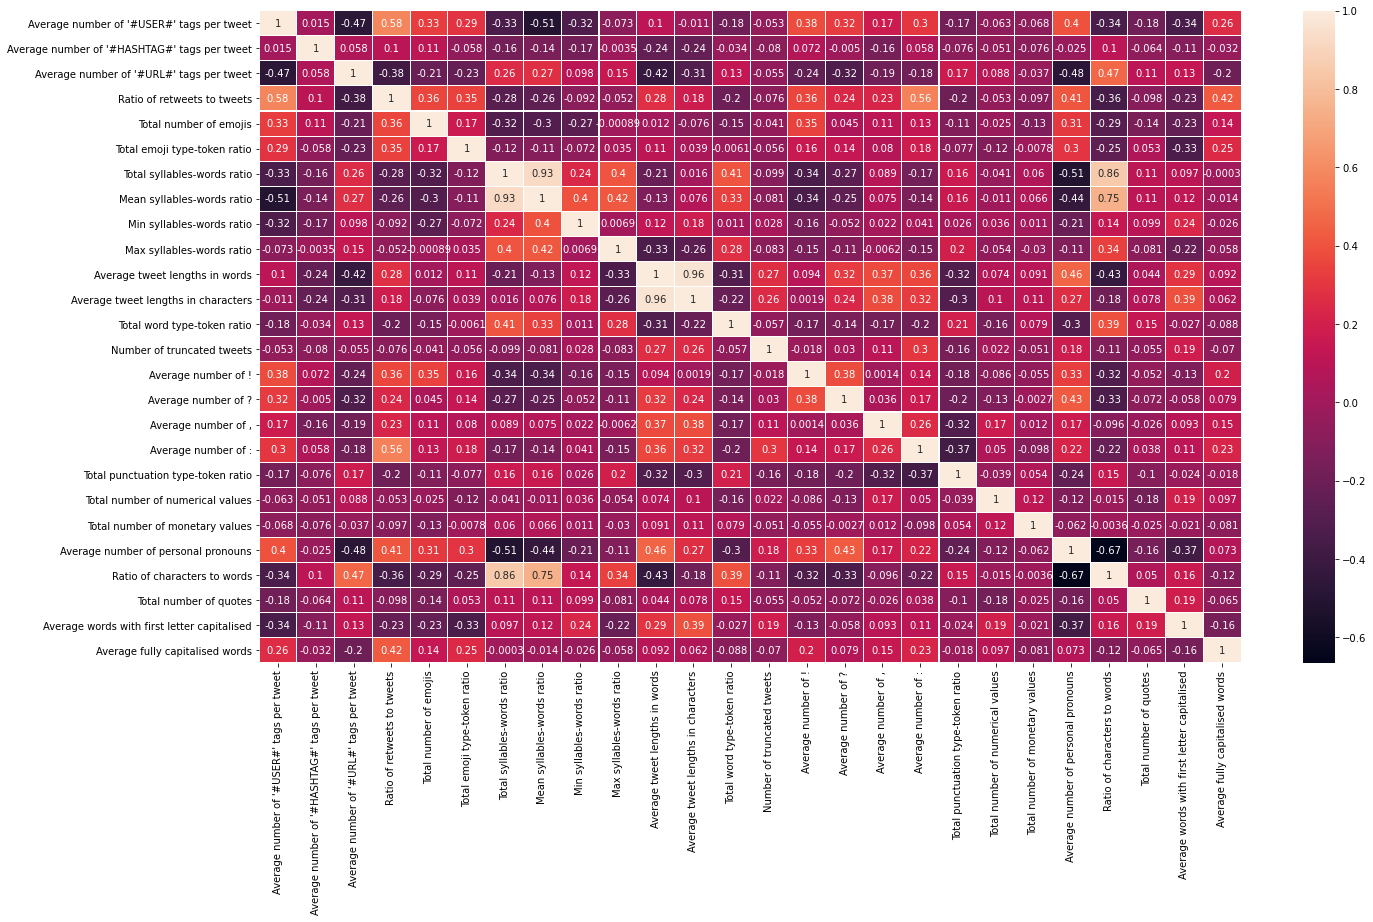

In [52]:
from seaborn import heatmap

def correlation_matrix(data, data_labels=None):
    data_correlation = pd.DataFrame(data, columns=data_labels).corr()

    fig, ax = plt.subplots(figsize=(22, 12))
    heatmap(data_correlation, linewidths=0.1, annot=True, ax=ax)
    plt.show()

correlation_matrix(tweet_read_stats_train, read_stats_feature_names)

We have a lot of features which are correlated, so without additional feature selection, 'multicollinearity' will mean than most ML models will perform worse on this data (with the exception of boosted tree algorithms).

By applying PCA, we transform the features, so that each feature is orthogonal to the others, hence removing the multicollinearity issue as no features are correlated.

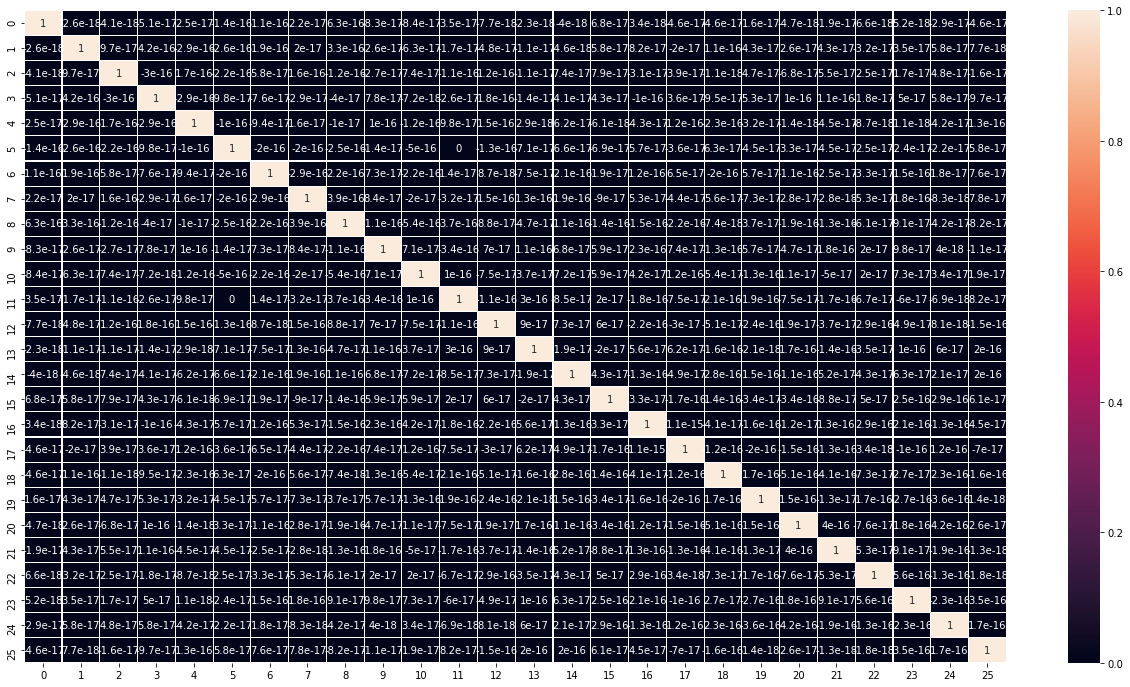

In [53]:
pca = PCA()
pca_tweet_read_stats_train = pca.fit_transform(tweet_read_stats_train)

correlation_matrix(pca_tweet_read_stats_train)

In [116]:
read_stats_search_best_params, read_stats_searches, read_stats_search_df = grid_search(
    tweet_read_stats_train, label_train, tweet_read_stats_val, label_val,
    param_grids=[{}, {}, {}, {"probability": [True]}])

Estimators:   0%|                                                                           | 0/4 [00:00<?, ?it/s]c:\users\joshh\desktop\uni\soton uni - yr 3\comp3200\fake-news-profiling\venv\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
Estimators:  25%|████████████████▊                                                  | 1/4 [00:01<00:04,  1.50s/it]

[15:41:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Estimators: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.99it/s]


In [117]:
read_stats_search_best_params

[('XGBClassifier', {}),
 ('RandomForestClassifier', {}),
 ('LogisticRegression', {}),
 ('SVC', {'probability': True})]

In [118]:
read_stats_search_df

,Estimator,Mean CV Loss,Mean CV F1,Mean CV Accuracy,Val Loss,Val Precision,Val Recall,Val F1,Val Accuracy
0,XGBClassifier,0.989960,0.551744,0.566667,0.620875,0.714286,0.666667,0.689655,0.700000
1,RandomForestClassifier,0.648437,0.595156,0.625000,0.671206,0.600000,0.600000,0.600000,0.600000
2,LogisticRegression,0.731965,0.611748,0.612500,0.710091,0.642857,0.600000,0.620690,0.633333
3,SVC,0.635959,0.640569,0.641667,0.647024,0.642857,0.600000,0.620690,0.633333


# Named Entity Recognition Model
* Extract user usage of named entities, and create a feature vector from counts of the different named entities
* "TakeLab at SemEval-2019 Task 4: Hyperpartisan News Detection" paper used an NER counter feature to help classify hyperpartisan news. 

In [121]:
import spacy

spacy_nlp = spacy.load("en_core_web_sm")
spacy_ner_labels = ["PERSON", "NORP", "FAC", "ORG", "GPE", "LOC", "PRODUCT", "EVENT", "WORK_OF_ART", "LAW", 
                    "LANGUAGE", "DATE", "TIME", "PERCENT", "MONEY", "QUANTITY", "ORDINAL", "CARDINAL"]

In [122]:
def named_entities_count_array(user_tweets):
    """ Extract the named entities from a users tweets, and return an array of counts for each entity """
    freq = dict.fromkeys(spacy_ner_labels, 0)
    for tweet in user_tweets:
        cleaned_tweet = clean_text(tweet, remove_digits=False, remove_tags=True)
        tweet_ne = spacy_nlp(cleaned_tweet).ents
        for entity in tweet_ne:
            freq[entity.label_] += 1
    
    return np.asarray(list(freq.values()))

In [123]:
# Extract NER count arrays
ner_stats_extractor = TweetStatsExtractor(extractors=[named_entities_count_array])

tweet_ner_stats_train = ner_stats_extractor.transform(tweet_train_processed)
tweet_ner_stats_val = ner_stats_extractor.transform(tweet_val_processed)
tweet_ner_stats_test = ner_stats_extractor.transform(tweet_test_processed)

In [124]:
ner_search_best_params, ner_searches, ner_search_df = grid_search(
    tweet_ner_stats_train, label_train, tweet_ner_stats_val, label_val,
    param_grids=[{}, {}, {}, {"probability": [True]}])

Estimators:   0%|                                                                           | 0/4 [00:00<?, ?it/s]c:\users\joshh\desktop\uni\soton uni - yr 3\comp3200\fake-news-profiling\venv\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
Estimators:  25%|████████████████▊                                                  | 1/4 [00:01<00:04,  1.53s/it]

[15:46:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Estimators: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.03it/s]


In [125]:
ner_search_best_params

[('XGBClassifier', {}),
 ('RandomForestClassifier', {}),
 ('LogisticRegression', {}),
 ('SVC', {'probability': True})]

In [126]:
ner_search_df

,Estimator,Mean CV Loss,Mean CV F1,Mean CV Accuracy,Val Loss,Val Precision,Val Recall,Val F1,Val Accuracy
0,XGBClassifier,0.895378,0.618507,0.629167,0.980002,0.684211,0.866667,0.764706,0.733333
1,RandomForestClassifier,0.639129,0.640797,0.633333,0.667203,0.666667,0.800000,0.727273,0.700000
2,LogisticRegression,0.708304,0.698836,0.687500,0.706445,0.625000,0.666667,0.645161,0.633333
3,SVC,0.642716,0.651555,0.637500,0.624942,0.611111,0.733333,0.666667,0.633333


# Sentiment Model
* Calculate the sentiment of a users tweets, and create a feature vector of these scores

In [127]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

In [128]:
def tweet_sentiment_scores(user_tweets):
    """ Returns the average, standard deviation, and max/min sentiment scores of the user """
    tweet_polarity = np.asarray([analyzer.polarity_scores(tweet)['compound'] for tweet in user_tweets])
    sent_mean = np.mean(tweet_polarity, axis=0)
    sent_std_dev = np.std(tweet_polarity)
    sent_max = np.max(tweet_polarity, axis=0)
    sent_min = np.min(tweet_polarity, axis=0)
    
    num_pos, num_neu, num_neg = 0, 0, 0
    for score in tweet_polarity:
        if score >= 0.05:
            num_pos += 1
        elif score <= -0.05:
            num_neg += 1
        else:
            num_neu += 1
    
    return np.asarray([sent_mean, sent_std_dev, sent_max, sent_min, num_pos, num_neu, num_neg])

def overall_sentiment(user_tweets):
    """ Returns the overall sentiment when all of the users tweets have been concatenated """
    return analyzer.polarity_scores(". ".join(user_tweets))['compound']

In [129]:
# Extract NER count arrays
sent_stats_extractor = TweetStatsExtractor(extractors=[tweet_sentiment_scores, overall_sentiment])

tweet_sent_stats_train = sent_stats_extractor.transform(tweet_train_processed)
tweet_sent_stats_val = sent_stats_extractor.transform(tweet_val_processed)
tweet_sent_stats_test = sent_stats_extractor.transform(tweet_test_processed)

sent_feature_names = [
    "Average tweet sentiment",
    "Standard deviation of tweet sentiments",
    "Max tweet sentiment",
    "Min tweet sentiment",
    "Number of positive tweets",
    "Number of neutral tweets",
    "Number of negative tweets",
    "Overall sentiment of the user",
]

In [130]:
sent_search_best_params, sent_searches, sent_search_df = grid_search(
    tweet_sent_stats_train, label_train, tweet_sent_stats_val, label_val,
    param_grids=[{}, {}, {}, {"probability": [True]}])

Estimators:   0%|                                                                           | 0/4 [00:00<?, ?it/s]c:\users\joshh\desktop\uni\soton uni - yr 3\comp3200\fake-news-profiling\venv\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
Estimators:  25%|████████████████▊                                                  | 1/4 [00:01<00:03,  1.22s/it]

[15:46:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Estimators: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.44it/s]


In [131]:
sent_search_best_params

[('XGBClassifier', {}),
 ('RandomForestClassifier', {}),
 ('LogisticRegression', {}),
 ('SVC', {'probability': True})]

In [132]:
sent_search_df

,Estimator,Mean CV Loss,Mean CV F1,Mean CV Accuracy,Val Loss,Val Precision,Val Recall,Val F1,Val Accuracy
0,XGBClassifier,0.972387,0.592333,0.587500,0.741040,0.714286,0.666667,0.689655,0.700000
1,RandomForestClassifier,0.674923,0.634123,0.620833,0.616171,0.714286,0.666667,0.689655,0.700000
2,LogisticRegression,0.680273,0.627512,0.616667,0.596262,0.733333,0.733333,0.733333,0.733333
3,SVC,0.675484,0.599185,0.591667,0.596876,0.611111,0.733333,0.666667,0.633333


# All Statistics Model
* Concatenate all of the statistical features and input them into a single model

In [51]:
# Stats data
all_stats_extractor = TweetStatsExtractor(extractors=[
    tag_counts,
    retweet_ratio,
    emojis_count,
    syllables_to_words_ratios,
    average_tweet_lengths,
    word_type_to_token_ratio,
    truncated_tweets,
    punctuation_counts,
    number_counts,
    average_personal_pronouns,
    char_to_words_ratio,
    quote_counts,
    capitalisation_counts,
    named_entities_count_array,
    tweet_sentiment_scores,
    overall_sentiment,
])
tweet_all_stats_train = all_stats_extractor.transform(tweet_train_processed)
tweet_all_stats_val = all_stats_extractor.transform(tweet_val_processed)
tweet_all_stats_test = all_stats_extractor.transform(tweet_test_processed)

In [52]:
all_search_best_params, all_search_df = grid_search(
    tweet_all_stats_train, label_train, tweet_all_stats_val, label_val)

Estimators: 100%|████████████████████████████████████████████████████████████████████| 5/5 [2:06:39<00:00, 1519.81s/it]


In [53]:
all_search_best_params

[('LogisticRegression',
  {'Estimator__C': 1,
   'Estimator__penalty': 'l1',
   'Estimator__solver': 'liblinear',
   'SelectKBest__k': 12}),
 ('SVC',
  {'Estimator__C': 1,
   'Estimator__kernel': 'rbf',
   'Estimator__probability': True,
   'SelectKBest__k': 44}),
 ('RandomForestClassifier',
  {'Estimator__criterion': 'gini',
   'Estimator__min_samples_leaf': 1,
   'Estimator__n_estimators': 50,
   'SelectKBest__k': 44}),
 ('GradientBoostingClassifier',
  {'Estimator__learning_rate': 0.1,
   'Estimator__loss': 'deviance',
   'Estimator__min_samples_leaf': 16,
   'Estimator__n_estimators': 25,
   'SelectKBest__k': 38}),
 ('KNeighborsClassifier',
  {'Estimator__n_neighbors': 10,
   'Estimator__weights': 'distance',
   'SelectKBest__k': 23})]

In [54]:
all_search_df

,Estimator,K best features,Mean CV Loss,Mean CV F1,Mean CV Accuracy,Val Loss,Val Precision,Val Recall,Val F1,Val Accuracy
0,LogisticRegression,12,0.646358,0.690278,0.675000,0.620576,0.714286,0.666667,0.689655,0.700000
1,SVC,44,0.594647,0.703312,0.695833,0.619752,0.615385,0.533333,0.571429,0.600000
2,RandomForestClassifier,44,0.571723,0.691513,0.704167,0.632008,0.727273,0.533333,0.615385,0.666667
3,GradientBoostingClassifier,38,0.599312,0.686386,0.675000,0.672012,0.666667,0.666667,0.666667,0.666667
4,KNeighborsClassifier,23,0.621102,0.683979,0.633333,0.678596,0.533333,0.533333,0.533333,0.533333


# Combining the Ensemble model

## Training the best performing models

In [7]:
# Readability Model - RandomForestClassifier
readability_model = Pipeline([
    ('Scaler', StandardScaler()),
    ('SelectKBest', SelectKBest()), 
    ('Estimator', RandomForestClassifier())
])
readability_model.set_params({
    'Estimator__criterion': 'gini',
    'Estimator__min_samples_leaf': 2,
    'Estimator__n_estimators': 200,
    'SelectKBest__k': 23,
})

readability_model.fit(tweet_read_stats_train, label_train)

In [ ]:
# NER Model - RandomForestClassifier
ner_model = Pipeline([
    ('Scaler', StandardScaler()),
    ('SelectKBest', SelectKBest()), 
    ('Estimator', RandomForestClassifier())
])
ner_model.set_params({
    'Estimator__criterion': 'entropy',
    'Estimator__min_samples_leaf': 8,
    'Estimator__n_estimators': 50,
    'SelectKBest__k': 7,
})

ner_model.fit(tweet_ner_stats_train, label_train)

In [ ]:
# Sentiment Model - RandomForestClassifier
sentiment_model = Pipeline([
    ('Scaler', StandardScaler()),
    ('SelectKBest', SelectKBest()), 
    ('Estimator', RandomForestClassifier())
])
sentiment_model.set_params({
    'Estimator__criterion': 'entropy',
    'Estimator__min_samples_leaf': 16,
    'Estimator__n_estimators': 200,
    'SelectKBest__k': 8,
})

sentiment_model.fit(tweet_sent_stats_train, label_train)

In [ ]:
# All Statistics Model - 
all_stats_model = Pipeline([
    ('SelectKBest', SelectKBest()), 
    ('Estimator', ?())
])
all_stats_model.set_params({

})

all_stats_model.fit(tweet_all_stats_train, label_train)